# P6. **BI Insights and Storytelling**

Joanna Farris  
04-20-2025  

  
-------------------  


## Section 1: The Business Goal

**Goal:**  
Understand regional and category-based sales performance in order to make smarter inventory distribution decisions for the upcoming quarter.

**Why it matters:**  
Different product categories perform better in different regions. By identifying where each product category sells best, the business can adjust inventory levels accordingly—reducing excess stock in low-performing areas and increasing availability in high-performing ones. This leads to more efficient operations, reduced waste, and improved customer satisfaction.  


### OLAP Analysis Plan

This notebook explores regional and category-based sales performance using OLAP techniques. The goal is to identify top-performing product categories in each region to support upcoming inventory decisions.

#### Steps:
1. Start Spark session and load tables from SQLite (sales, product, customer)
2. Slice sales data to include only sales from 2023 onward
3. Dice data by product category and region (store-based and customer-based)
4. Drill down into time dimensions: year → quarter → month
5. Aggregate total sales by relevant groupings
6. Visualize results with bar and line charts
7. Summarize insights and suggest business actions  

-----------


## Section 2: Data Source

This analysis uses data stored in a local SQLite data warehouse and accessed via JDBC.

**Tables and Key Columns:**

- `sales`: `sale_date`, `store_id`, `product_id`, `customer_id`, `sale_amount_usd`
- `product`: `product_id`, `category`
- `customer`: `customer_id`, `region`

All data was loaded into Spark DataFrames and will be used throughout the analysis for filtering, joining, grouping, and aggregating.

--------


## Section 3: Tools

- **JupyterLab** for step-by-step development and documentation
- **Python with PySpark** for data transformation and OLAP analysis
- **SQLite (via JDBC)** as the data warehouse
- **Seaborn / Matplotlib** for visualizations

This toolset allows for transparent, flexible, and reproducible analysis. Spark provides scalable querying and transformations, while Pandas supports visualization through Python plotting libraries.


## Section 4: Workflow & Logic

1. **Slicing** – Filtered sales to include only those from 2023 onward
2. **Dicing** – Grouped sales by product category and region:
   - Store-based region (mapped from `store_id`)
   - Customer-based region (from `customer.region`)
3. **Drilldown** – Added `year`, `quarter`, and `month` fields to analyze time-based trends
4. **Aggregation** – Used `sum(sale_amount_usd)` to total sales
5. **Visualization** – Converted Spark DataFrames to Pandas and plotted:
   - Line charts for quarterly and monthly sales
   - Bar charts comparing regional and category-based sales
6. **Comparison** – Evaluated how business insights change when grouping by store vs. customer region


In [ ]:
# Organize imports, define paths 

# Core imports
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, year, month, quarter, sum as _sum

# Define paths using pathlib
PROJECT_ROOT = Path("/Users/joannafarris/Projects/smart-store-joannafarris")
JDBC_JAR_PATH = PROJECT_ROOT / "lib" / "sqlite-jdbc-3.49.1.0.jar"
DB_PATH = PROJECT_ROOT / "data" / "dw" / "smart_sales.db"

# Define the JDBC URL
DB_URL = f"jdbc:sqlite:{str(DB_PATH)}"

In [ ]:
# Start spark session

# Stop existing Spark session if one is already active
if 'spark' in locals() and spark is not None:
    spark.stop()

# Create SparkSession with the JDBC jar
spark = SparkSession.builder \
    .appName("SmartSales") \
    .config("spark.jars", str(JDBC_JAR_PATH)) \
    .config("spark.driver.extraClassPath", str(JDBC_JAR_PATH)) \
    .getOrCreate()

# Set Spark's log level to ERROR to reduce output
spark.sparkContext.setLogLevel("ERROR")

In [ ]:
# Load tables

# customer table
try:
    df_customer = spark.read.format("jdbc") \
        .option("url", DB_URL) \
        .option("dbtable", "customer") \
        .option("driver", "org.sqlite.JDBC") \
        .load()
    df_customer.show()
except Exception as e:
    print(f"Error loading data: {e}")

# product table
try:
    df_product = spark.read.format("jdbc") \
        .option("url", DB_URL) \
        .option("dbtable", "product") \
        .option("driver", "org.sqlite.JDBC") \
        .load()
    df_product.show()
except Exception as e:
    print(f"Error loading data: {e}")

# sales table
try:
    df_sales = spark.read.format("jdbc") \
        .option("url", DB_URL) \
        .option("dbtable", "sales") \
        .option("driver", "org.sqlite.JDBC") \
        .load()
    df_sales.show()
except Exception as e:
    print(f"Error loading data: {e}")        

### Slicing: Filter sales data to only include records from 2023 and later.

In [92]:
# Slice: Filter sales from 2023 onward
df_sales = df_sales.filter(df_sales.sale_date >= "2023-01-01")

### Dicing: Add a `region` column based on `store_id` to allow grouping by store region.

In [93]:
df_sales = df_sales.withColumn("region", 
    when(df_sales["store_id"] == 401, "East")
    .when(df_sales["store_id"] == 402, "East")
    .when(df_sales["store_id"] == 403, "West")
    .when(df_sales["store_id"] == 404, "West")
    .when(df_sales["store_id"] == 405, "North")
    .when(df_sales["store_id"] == 406, "South")
    .otherwise("Unknown"))

Join the sales data with the product table to access the `category` column needed for grouping.

In [94]:
df_joined = df_sales.join(df_product, on="product_id")

Group and aggregate the data by product category and store region to prepare for visual analysis.

In [95]:
df_result_store_region = df_joined.groupBy("category", "region") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("category", "region")

df_result_store_region.show()


+-----------+------+-----------+
|   category|region|total_sales|
+-----------+------+-----------+
|   Clothing|  East|       4078|
|   Clothing| North|       5044|
|   Clothing| South|       1256|
|   Clothing|  West|       3032|
|Electronics|  East|      58389|
|Electronics| North|      11178|
|Electronics| South|      10416|
|Electronics|  West|      14453|
|     Sports|  East|        275|
|     Sports| North|        257|
|     Sports| South|         39|
|     Sports|  West|         98|
+-----------+------+-----------+



### Alternate Dicing: Group by product category and the region where the customer lives.

This alternative breakdown joins the sales, product, and customer tables and uses `customer.region` instead of store-based region to group total sales. Comparing the two approaches helps reveal differences in interpretation based on the region dimension.

In [96]:
sales = df_sales.alias("s")
product = df_product.alias("p")
customer = df_customer.alias("c")

df_combined = sales.join(product, on="product_id").join(customer, on="customer_id")

df_result_customer_region = df_combined.groupBy("category", customer["region"]) \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("category", "region")

df_result_customer_region.show()


+-----------+------+-----------+
|   category|region|total_sales|
+-----------+------+-----------+
|   Clothing|  East|       4078|
|   Clothing| North|       3581|
|   Clothing| South|       3384|
|   Clothing|  West|       2367|
|Electronics|  East|      58389|
|Electronics| North|       1688|
|Electronics| South|      20706|
|Electronics|  West|      13653|
|     Sports|  East|        275|
|     Sports| North|        336|
|     Sports| South|         39|
|     Sports|  West|         19|
+-----------+------+-----------+



### Drilldown: Add `year`, `quarter`, `month`, and `week` columns to support time-based breakdowns.

These time-based dimensions allow us to explore seasonal trends and week-by-week sales performance.


In [97]:
df_sales = df_sales.withColumn("year", year("sale_date")) \
                   .withColumn("quarter", quarter("sale_date")) \
                   .withColumn("month", month("sale_date")) \
                   .withColumn("week", weekofyear("sale_date"))


Aggregate total sales by year, quarter, month, and week to observe patterns and trends over time.


In [98]:
# Year
df_sales.groupBy("year") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("year") \
    .show()

# Quarter
df_sales.groupBy("quarter") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("quarter") \
    .show()

# Month
df_sales.groupBy("month") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("month") \
    .show()

# Week
df_sales.groupBy("week") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("week") \
    .show()


+----+-----------+
|year|total_sales|
+----+-----------+
|2024|     108515|
+----+-----------+

+-------+-----------+
|quarter|total_sales|
+-------+-----------+
|      1|      33161|
|      2|      34359|
|      3|      35143|
|      4|       5852|
+-------+-----------+

+-----+-----------+
|month|total_sales|
+-----+-----------+
|    1|       6428|
|    2|      14584|
|    3|      12149|
|    4|      16939|
|    5|      10980|
|    6|       6440|
|    7|      21032|
|    8|       4621|
|    9|       9490|
|   10|       5852|
+-----+-----------+

+----+-----------+
|week|total_sales|
+----+-----------+
|   1|         58|
|   3|        530|
|   4|       2496|
|   5|       3344|
|   6|       8433|
|   8|       5216|
|   9|        935|
|  12|       7316|
|  13|       4833|
|  14|        500|
|  15|       2415|
|  16|       6656|
|  17|       7251|
|  18|        351|
|  19|       7741|
|  20|       2712|
|  22|        293|
|  23|        738|
|  24|        893|
|  25|       4809|
+----+---

### Convert Aggregated Results to Pandas for Visualization


In [99]:
# Store-based region results
df_store_region_pd = df_result_store_region.toPandas()

# Customer-based region results
df_customer_region_pd = df_result_customer_region.toPandas()

# Monthly totals
df_monthly = df_sales.groupBy("month") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("month")

df_monthly_pd = df_monthly.toPandas()

# Weekly totals
df_weekly = df_sales.groupBy("week") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("week")

df_weekly_pd = df_weekly.toPandas()

# Quarterly totals
df_quarterly = df_sales.groupBy("quarter") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("quarter")

df_quarterly_pd = df_quarterly.toPandas()


### Line Chart: Quarterly Sales Trend


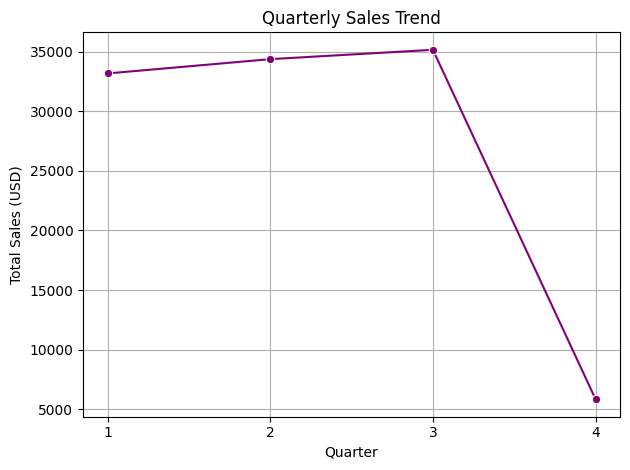

In [100]:
sns.lineplot(data=df_quarterly_pd, x="quarter", y="total_sales", marker="o", color=sns.color_palette("RdPu")[5])
plt.title("Quarterly Sales Trend")
plt.xlabel("Quarter")
plt.ylabel("Total Sales (USD)")
plt.grid(True)
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()


### Line Chart: Monthly Sales Trend

This chart shows how total sales varied across months, offering more granular drilldown beyond quarterly trends.

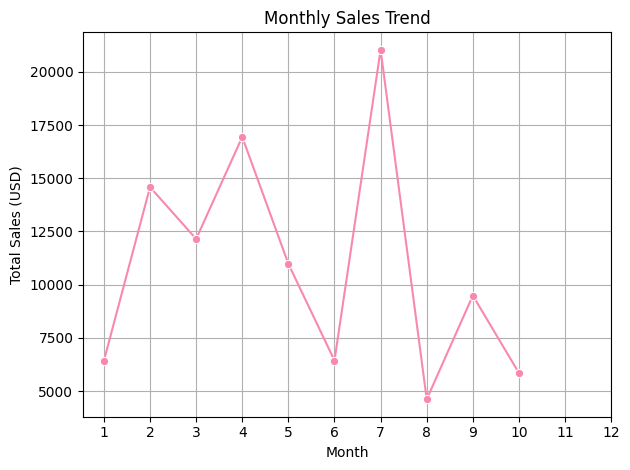

In [101]:
sns.lineplot(data=df_monthly_pd, x="month", y="total_sales", marker="o", color=sns.color_palette("RdPu")[2])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (USD)")
plt.grid(True)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()


### Bar Chart: Total Sales by Product Category and Store Region

This grouped bar chart shows how different product categories performed across store regions. It uses store-based region mapping from `store_id`.

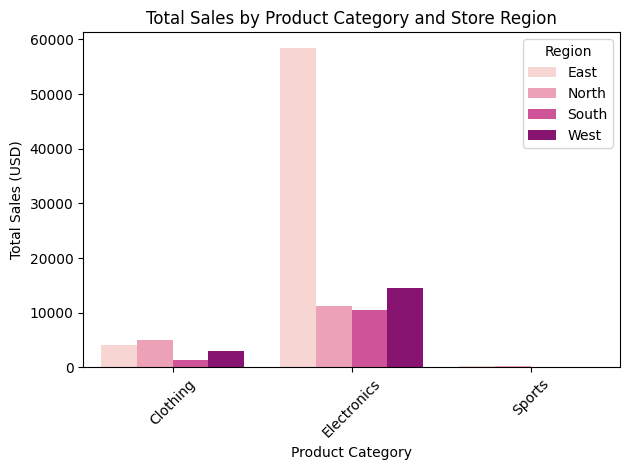

In [102]:
sns.barplot(data=df_store_region_pd, x="category", y="total_sales", hue="region", palette="RdPu")
plt.title("Total Sales by Product Category and Store Region")
plt.xlabel("Product Category")
plt.ylabel("Total Sales (USD)")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


### Bar Chart: Total Sales by Product Category and Customer Region

This chart groups total sales by product category and the region where the customer lives, offering a different perspective than store-based performance. Comparing both charts highlights how business insights can shift depending on which regional dimension is used.
``


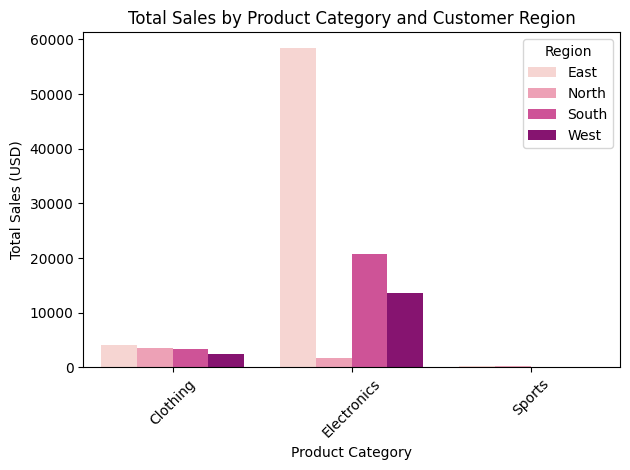

In [103]:
sns.barplot(data=df_customer_region_pd, x="category", y="total_sales", hue="region", palette="RdPu")
plt.title("Total Sales by Product Category and Customer Region")
plt.xlabel("Product Category")
plt.ylabel("Total Sales (USD)")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


### Compare Total Sales by Region Type

In this section, we compare total sales grouped by **store region** (based on `store_id`) and **customer region** (based on `customer.region`). This helps evaluate how different interpretations of "region" can lead to different insights, and how grouping logic can impact decision-making.


In [104]:
# Total Sales by Store Region
df_sales_by_store_region = df_sales.groupBy("region") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("region")

df_sales_by_store_region_pd = df_sales_by_store_region.toPandas()
df_sales_by_store_region_pd

,region,total_sales
0,East,62742
1,North,16479
2,South,11711
3,West,17583


In [105]:
# Total Sales by Customer Region
df_sales_by_customer_region = df_combined.groupBy(customer["region"]) \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("region")

df_sales_by_customer_region_pd = df_sales_by_customer_region.toPandas()
df_sales_by_customer_region_pd

,region,total_sales
0,East,62742
1,North,5605
2,South,24129
3,West,16039


### Bar Chart Comparison: Store Region vs Customer Region

In [106]:
df_sales_by_customer_region = df_combined.groupBy(customer["region"]) \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("region")

df_sales_by_customer_region_pd = df_sales_by_customer_region.toPandas()


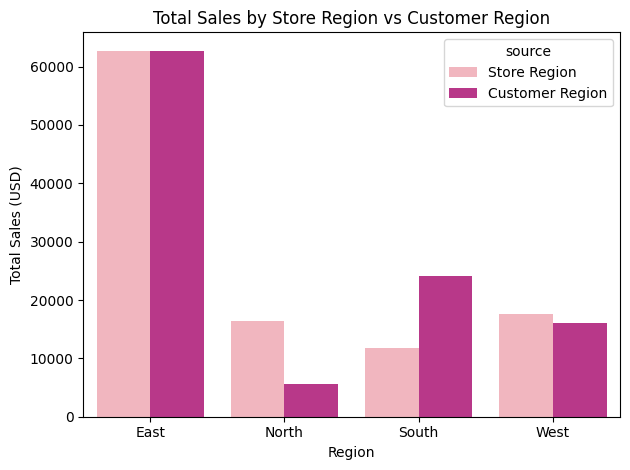

In [107]:
# Add column to identify type
df_sales_by_store_region_pd["source"] = "Store Region"
df_sales_by_customer_region_pd["source"] = "Customer Region"

# Rename for consistency
df_sales_by_store_region_pd = df_sales_by_store_region_pd.rename(columns={"region": "region"})
df_sales_by_customer_region_pd = df_sales_by_customer_region_pd.rename(columns={"region": "region"})

# Combine both
df_combined_regions = pd.concat([df_sales_by_store_region_pd, df_sales_by_customer_region_pd])

# Plot
sns.barplot(data=df_combined_regions, x="region", y="total_sales", hue="source", palette="RdPu")
plt.title("Total Sales by Store Region vs Customer Region")
plt.xlabel("Region")
plt.ylabel("Total Sales (USD)")
plt.tight_layout()
plt.show()



### Insight

This chart highlights how total sales vary depending on whether we group by **store region** or **customer region**. 

In some cases, the sales totals are similar, but in others, there are noticeable differences. This discrepancy suggests that customers may be shopping in regions outside of their listed home region. 

Understanding this difference is important: if we grouped only by customer region, we might misallocate inventory or miss sales opportunities at specific store locations. Store-based grouping provides a more direct view of where sales are actually taking place.


## Section 5: Results

The analysis revealed how product categories perform across regions and time.

### Key Findings

- **Quarterly Sales Trend:** Sales totals were relatively stable across quarters, with no extreme spikes or drops. This suggests consistent performance over time, even if the data is randomly generated.

- **Monthly Sales Trend:** While no obvious seasonal patterns emerged, the month-by-month breakdown demonstrates how a more granular time drilldown can uncover subtle shifts in performance.

- **Store Region vs. Customer Region (Total Sales):** The totals differed between customer region and store region groupings, confirming that customers often make purchases outside of their listed home region.

- **Sales by Product Category and Store Region:** Certain product categories performed better in specific store regions, which could guide inventory stocking decisions based on actual point-of-sale performance.

- **Sales by Product Category and Customer Region:** Grouping by customer region presented a slightly different picture, reinforcing the importance of selecting the right dimension for analysis.

### Visualizations Provided
- Line chart: Total sales by quarter
- Line chart: Total sales by month
- Bar chart: Product category × store region
- Bar chart: Product category × customer region
- Bar chart: Store region vs. customer region (total sales)


## Section 6: Suggested Business Action

Based on the analysis, the following business actions are recommended:

- **Adjust inventory distribution by region:**  
  Focus inventory for each product category in the store regions where those categories perform best. This reduces overstock in low-performing areas and improves availability in high-demand zones.

- **Prioritize store-based data for operational decisions:**  
  Since sales often occur outside the customer's home region, store-based grouping provides a more accurate reflection of demand at the point of sale. Store region should be used when making decisions about stocking and logistics.

- **Use time-based trends for planning cycles:**  
  While this dataset doesn't show strong seasonality, the ability to analyze sales


## Section 7: Challenges

Several challenges arose during the project and were resolved through experimentation and clarification:

- **Region ambiguity:**  
  The `customer` table included a `region` column, but it quickly became clear that grouping by store location (via `store_id`) provided a more accurate view of sales performance. A new `region` column was created by mapping store IDs manually.

- **Joining multiple tables:**  
  Performing multiple joins required consistent use of aliases and awareness of column overlaps. Care was taken to reference the correct `region` (customer vs. store) when grouping data.

- **Interpreting synthetic data:**  
  The dataset was randomly generated, so the patterns were not expected to reflect real-world seasonality or demand. Still, the goal was to demonstrate OLAP techniques, and the results served that purpose effectively.

